**Examen II. Gabriel Alvarez Castrillo**

**1. Distribuciones de probabilidad (35%):**

## Derivación de la expresión para generar la distribución de Boltzmann

Queremos generar números aleatorios que sigan la distribución de Boltzmann:

$$
P(E) = \beta e^{-\beta E}
$$

dada una distribución uniforme $Q(z) = 1$ con $z \in [0,1)$.

### **Transformada inversa**

El método de la transformada inversa nos dice que si una variable aleatoria \(z\) sigue una distribución uniforme en \([0,1)\), podemos obtener una variable \(E\) con la distribución deseada resolviendo:

$$
\int_0^E P(E') dE' = z.
$$

Sustituyendo la función de Boltzmann:

$$
\int_0^E \beta e^{-\beta E'} dE' = z.
$$

Calculamos la integral:

$$
\left[-e^{-\beta E'} \right]_0^E = 1 - e^{-\beta E} = z.
$$

Despejamos \(E\):

$$
1 - z = e^{-\beta E}.
$$

Aplicamos logaritmo natural a ambos lados:

$$
\ln(1 - z) = -\beta E.
$$

Finalmente, despejamos \(E\):

$$
E = -\frac{1}{\beta} \ln(1 - z).
$$

Dado que \(z\) es uniforme en \([0,1)\), podemos reemplazar \(1 - z\) por \(z\), ya que sigue teniendo la misma distribución:

$$
E = -\frac{1}{\beta} \ln(z).
$$

Esta es la expresión buscada para generar números aleatorios con la distribución de Boltzmann a partir de una distribución uniforme.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generar_boltzmann(beta, N=50000):
    z = np.random.uniform(0, 1, N) # Nombres de variables acorde a lo antes puesto 
    E = -np.log(z) / beta          # Nombres de variables acorde a lo antes puesto 
    return E

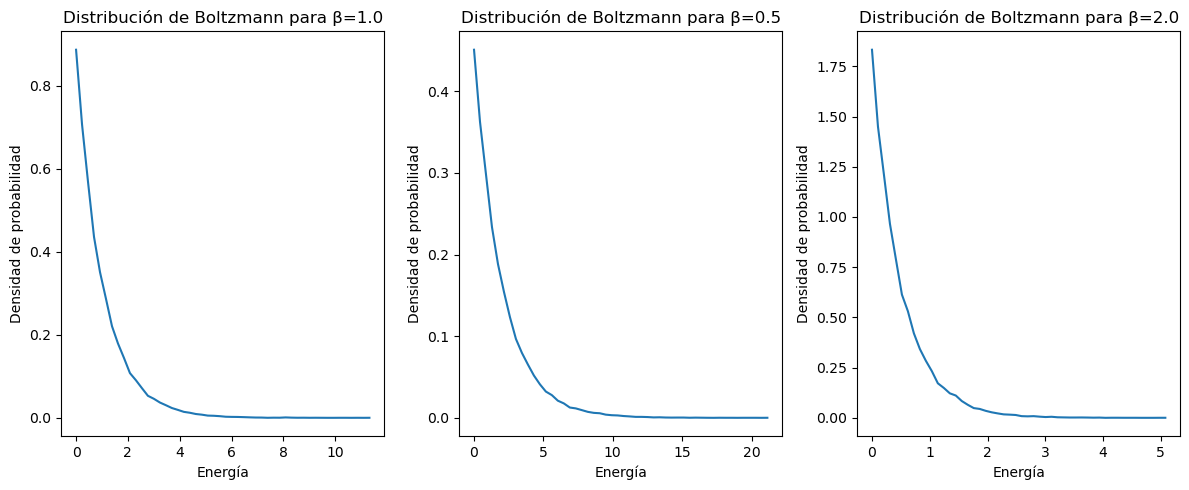

In [51]:
# Parámetros
betas = [1.0, 0.5, 2.0]
N = 50000
bins = 50
plt.figure(figsize=(12, 5))
for i, beta in enumerate(betas):
    E = generar_boltzmann(beta, N)
    # Histograma usando numpy
    hist, bin_edges = np.histogram(E, bins=bins, density=True)

    # Graficar el histograma
    plt.subplot(1, 3, i + 1)
    plt.plot(bin_edges[:-1], hist)
    plt.title(f"Distribución de Boltzmann para β={beta}")
    plt.xlabel('Energía')
    plt.ylabel('Densidad de probabilidad')
    

plt.tight_layout()
plt.show()


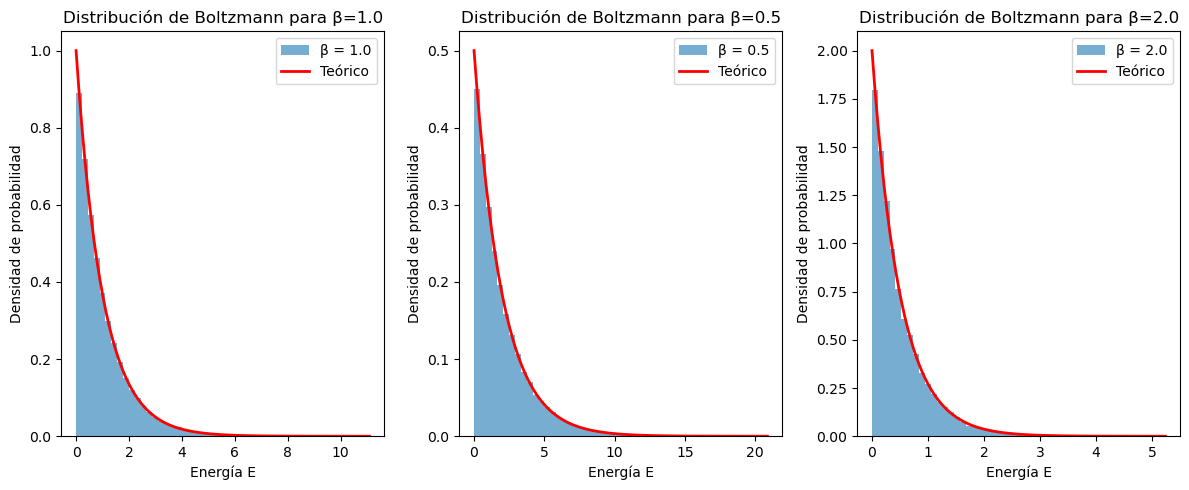

In [52]:
plt.figure(figsize=(12, 5))

for i, beta in enumerate(betas):
    E = generar_boltzmann(beta, N)
    
    # Histograma usando matplotlib
    plt.subplot(1, 3, i + 1)
    plt.hist(E, bins=bins, density=True, alpha=0.6, label=f"β = {beta}")
    
    # Función teórica
    E_teorico = np.linspace(0, max(E), 100)
    P_teorico = beta * np.exp(-beta * E_teorico)
    plt.plot(E_teorico, P_teorico, 'r-', lw=2, label="Teórico")
    
    plt.xlabel("Energía E")
    plt.ylabel("Densidad de probabilidad")
    plt.legend()
    plt.title(f"Distribución de Boltzmann para β={beta}")
    

plt.tight_layout()
plt.show()

**2. Monte Carlo (35%):**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Función a integrar
def func(t):
    return np.exp(-t**2)

In [ ]:
# Método de Monte Carlo de punto medio
def monte_carlo_punto_medio(N,t_min,t_max):
    t_random  = np.random.uniform(t_min, t_max, N)     # Generamos N muestras aleatorias de t en el rango de [t_min,t_max] o [0,1] en nuestro caso
    integral_estimate = (t_max-t_min)*np.mean(func(t_random ))  # Aproximación de la integral
    # Note que usar np.mean() es lo mismo que hacer la sumatoria de 1 hasta N de la función evaluada en t_i, y luego dividirlo entre N
    return integral_estimate

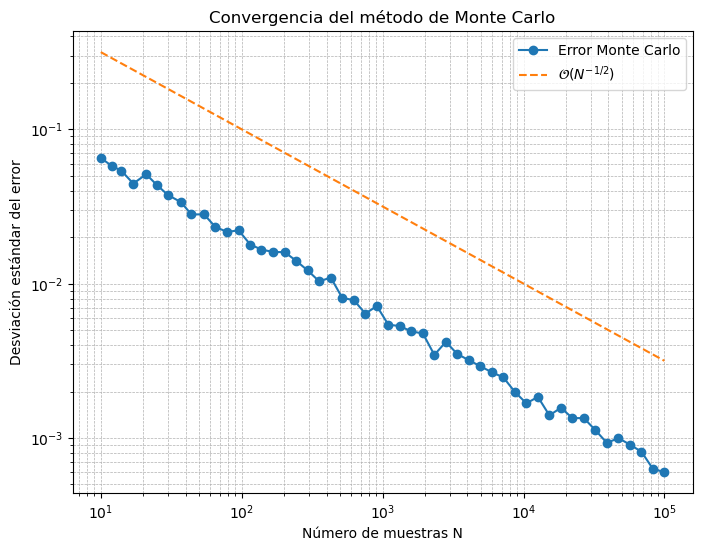

In [56]:
# Limites de la integral
t_min = 0
t_max = 1
# Valores de N a evaluar
N_values = np.logspace(1, 5, 50, dtype=int)  # De 10 a 10^5 en 50 puntos
errors = []

# Calcular errores usando desviación estándar
for N in N_values:
    Int_N_values = []
    for _ in range(100):  # Realizamos 100 estimaciones para cada N
        Int_N_values.append(monte_carlo_punto_medio(N, t_min, t_max))
    
    # Calcular la desviación estándar de las estimaciones
    std_dev = np.std(Int_N_values)
    error = std_dev  # Usamos la desviación estándar como el error segun lo visto en clase
    errors.append(error)

# Graficar el error
plt.figure(figsize=(8,6))
plt.loglog(N_values, errors, marker='o', linestyle='-', label='Error Monte Carlo')
plt.loglog(N_values, N_values**-0.5, linestyle='--', label=r'$\mathcal{O}(N^{-1/2})$')
plt.xlabel('Número de muestras N')
plt.ylabel('Desviación estándar del error')
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.title('Convergencia del método de Monte Carlo')
plt.show()

El gráfico muestra cómo el error disminuye conforme aumenta $N$, siguiendo la tendencia esperada de $ O(N^{-1/2}) $, representada por la línea punteada. Esto confirma el comportamiento característico de los métodos de Monte Carlo, donde la convergencia es relativamente lenta en comparación con otros métodos numéricos como cuadratura gaussiana.


**3. Paralelismo de memoria distribuida (30%):**

El codigo es:

```c++
#include <iostream>
#include <mpi.h>

int main(int argc, char* argv[]) {
    // Inicializamos MPI
    MPI_Init(&argc, &argv);

    // Obtenemos el rango (ID) del proceso y el tamaño total de procesos
    int rank, size;
    MPI_Comm_rank(MPI_COMM_WORLD, &rank);
    MPI_Comm_size(MPI_COMM_WORLD, &size);

    // Cada proceso tiene un buffer con su propio rango
    int buffer = rank;

    // Realizamos N iteraciones (donde N es el número de procesos)
    for (int iteration = 0; iteration < size; ++iteration) {
        // El proceso p envía su valor en buffer al siguiente proceso
        int send_rank = buffer;

        if (rank == size - 1) { // El último proceso envía al primer proceso
            MPI_Send(&send_rank, 1, MPI_INT, 0, 0, MPI_COMM_WORLD); // Envío bloqueante
            MPI_Recv(&buffer, 1, MPI_INT, rank - 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE); // Recepción bloqueante
        } else {
            // El proceso p envía al siguiente proceso y recibe del anterior
            MPI_Send(&send_rank, 1, MPI_INT, rank + 1, 0, MPI_COMM_WORLD); // Envío bloqueante
            MPI_Recv(&buffer, 1, MPI_INT, rank - 1, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE); // Recepción bloqueante
        }

        // En la iteración, el proceso 0 escribe en terminal el contenido de su buffer
        if (rank == 0) {
            std::cout << "Iteración " << iteration << ": Buffer en el proceso 0 = " << buffer << std::endl;
        }
    }

    // Después de N iteraciones, el proceso 0 recibe nuevamente el valor 0
    if (rank == 0) {
        std::cout << "Iteración final: El valor recibido por el proceso 0 es " << buffer << std::endl;
    }

    // Finalizamos MPI
    MPI_Finalize();
    return 0;
}
```

Para compilarlo hacemos:
```
mpic++ -o circular.x circular.cpp
```

Y para ejecutarlo hacemos:
```
mpiexec -n 4 ./circular.x
```
En este caso lo hacemos para cuatro procesos

El resultado esperado es:
```
Iteración 0: Buffer en el proceso 0 => 1
Iteración 1: Buffer en el proceso 0 => 2
Iteración 2: Buffer en el proceso 0 => 3
Iteración 3: Buffer en el proceso 0 => 0
Iteración final: El valor recibido por el proceso 0 es 0
```